In [1]:
import torch.utils
from torch.autograd import Variable
import numpy as np
from torch.utils.data import Dataset, ConcatDataset
import torch.nn as nn
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from torch.optim import SGD, Adam
import torch.optim as optim
import matplotlib.pyplot as plt
from captum.attr import DeepLift
import os
from tqdm import tqdm

from utils import *

In [2]:
model_type = "FFN_Model"
model_name = "myLinear340_bs_128_lr_1e-3_ep_50"

model_type = "LSTM_Model"
model_name = "CORRECT_LSTM"


test_set = CustomDataset(f'{model_type}/one__hot_Ntest_data.txt', f'{model_type}/Ntest_targets.txt')
train_set = CustomDataset(f'{model_type}/one__hot_Ntrain_data.txt', f'{model_type}/Ntrain_targets.txt')

test_loader =torch.utils.data.DataLoader(
    test_set,
    batch_size=490_612,#490_612,
    shuffle=False,
    collate_fn=lambda d: ([x[0] for x in d], [x[1] for x in d]),
)

torch.backends.cudnn.enabled=False


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
CUDA = torch.cuda.is_available()
print(f"working on GPU: {CUDA}")

MODEL_CLASS = MyRegression if "FFN" in model_type else PPS

model = MODEL_CLASS(340,3)
model.load_state_dict(torch.load(f'{model_type}/{model_name}/checkpoint'))
model.to(device)
# model.eval()
torch.manual_seed(123)
np.random.seed(123)

X_test, y_test=next(iter(test_loader))
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test)

dl = DeepLift(model)

working on GPU: True


/media/HDD/bportelli/env/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


/media/HDD/bportelli/env/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/media/HDD/bportelli/env/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


x torch.Size([2000, 17, 20])
out torch.Size([2, 2000, 64])
out torch.Size([2000, 128])
out torch.Size([2000, 32])
out torch.Size([2000, 3])


AssertionError: 

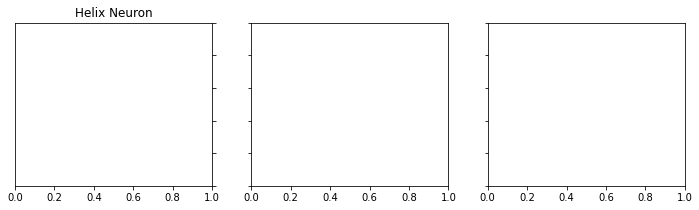

In [3]:

# PLOT_DIAG2(dl, X_test, y_test, absolute=True)
# # plt.savefig(f"plots/{model_type}.deeplift.avg.pdf", dpi=300)
# plt.show()

PLOT_DIAG(dl, X_test, y_test, absolute=True)
plt.savefig(f"plots/{model_type}.deeplift.avg.pdf", dpi=300)
plt.show()



PLOT_DIAG(dl, X_test, y_test, absolute=True, avg=False)
plt.savefig(f"plots/{model_type}.deeplift.all.pdf", dpi=300)
plt.show()

# PLOT_DIAG2(dl, X_test, y_test, absolute=True, avg=False)
# # plt.savefig(f"plots/{model_type}.deeplift.all.pdf", dpi=300)
# plt.show()

In [4]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# print("TEST")
# acc_test, real_test, pred_test = get_accuracy(model, test_set)
# print(round(acc_test*100,2))

# M = confusion_matrix(
#     y_true=real_test,
#     y_pred=pred_test,
#     normalize="true",
# )
# ConfusionMatrixDisplay(
#     M,
#     display_labels=["Helix", "Coil", "Strand"],
# ).plot(cmap="Blues")
# plt.show()

In [5]:
# import pandas as pd
# pred_summary_test = pd.DataFrame({
#     "real": real_test,
#     "pred": pred_test,
# })
# pred_summary_test.to_pickle(f'{model_type}/{model_name}/pred_summary_test.pickle')
# pred_summary_test

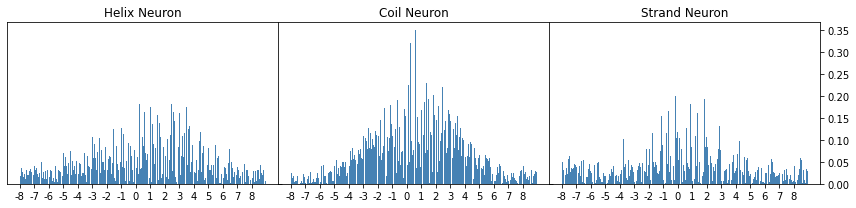

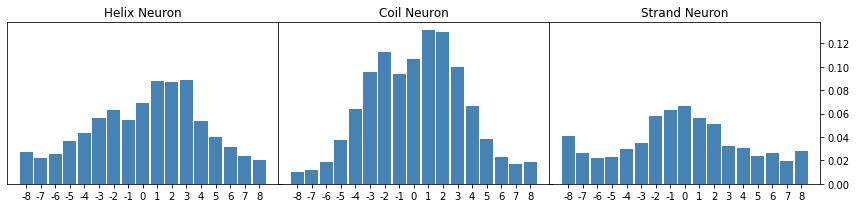

In [6]:
if "FFN" in model_type:
    LABELS = ["-"+str(x) for x in range(8,0,-1)]+[str(0)]+[str(x) for x in range(1,9,1)]
    w0,w1,w2 = model.linear.weight.detach().cpu()[0], model.linear.weight.detach().cpu()[1], model.linear.weight.detach().cpu()[2]

    def get_sign_color(w0, pos="steelblue", neg="steelblue"):
        return [neg if x<0 else pos for x in w0]


    fig, axs = plt.subplots(1,3, figsize=(12,3), sharey=True)
    for i,ax in enumerate(axs):
        ax.yaxis.tick_right()
        ax.set_xticks([x for x in range(17*20) if (x)%20==0])
        ax.set_xticklabels(LABELS)
        # ax.tick_params(axis='x', rotation=90)
        if i == 2:
            ax.yaxis.set_tick_params(labelright=True, labelleft=False)
        else:
            for label in ax.get_yticklabels():
                label.set_visible(False)
    axs[0].bar(range(17*20), w0.abs(), color=get_sign_color(w0), width=.9)
    axs[1].bar(range(17*20), w1.abs(), color=get_sign_color(w1), width=.9)
    axs[2].bar(range(17*20), w2.abs(), color=get_sign_color(w2), width=.9)
    axs[0].set_title(f"Helix Neuron")
    axs[1].set_title(f"Coil Neuron")
    axs[2].set_title(f"Strand Neuron")

    plt.tight_layout()
    fig.subplots_adjust(hspace=0.1, wspace=0)
    plt.savefig(f"plots/{model_type}.weights.all.pdf", dpi=300)
    plt.show()

    avg_w0 = np.reshape(w0, (17,20)).mean(1)
    avg_w1 = np.reshape(w1, (17,20)).mean(1)
    avg_w2 = np.reshape(w2, (17,20)).mean(1)

    abs_avg_w0 = np.reshape(w0.abs(), (17,20)).mean(1)
    abs_avg_w1 = np.reshape(w1.abs(), (17,20)).mean(1)
    abs_avg_w2 = np.reshape(w2.abs(), (17,20)).mean(1)

    fig, axs = plt.subplots(1,3, figsize=(12,3), sharey=True)
    for i,ax in enumerate(axs):
        ax.yaxis.tick_right()
        ax.set_xticks(range(len(abs_avg_w0)))
        ax.set_xticklabels(LABELS)
        if i == 2:
            ax.yaxis.set_tick_params(labelright=True, labelleft=False)
        else:
            for label in ax.get_yticklabels():
                label.set_visible(False)
    axs[0].bar(range(17), abs_avg_w0, color=get_sign_color(avg_w0), width=.9)
    axs[1].bar(range(17), abs_avg_w1, color=get_sign_color(avg_w1), width=.9)
    axs[2].bar(range(17), abs_avg_w2, color=get_sign_color(avg_w2), width=.9)
    axs[0].set_title(f"Helix Neuron")
    axs[1].set_title(f"Coil Neuron")
    axs[2].set_title(f"Strand Neuron")

    plt.tight_layout()
    fig.subplots_adjust(hspace=0.1, wspace=0)
    plt.savefig(f"plots/{model_type}.weights.avg.pdf", dpi=300)
    plt.show()

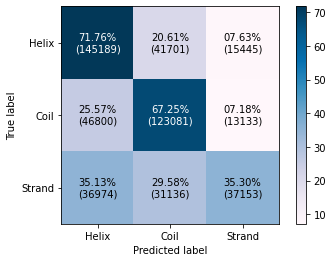

In [7]:
import pandas as pd
from sklearn.metrics import confusion_matrix
df = pd.read_pickle(f'{model_type}/{model_name}/pred_summary_test.pickle')

M=confusion_matrix(df.real.tolist(), df.pred.tolist())
M_norm = (M.T/M.sum(1)).T*100
heatmap = plt.imshow(M_norm, cmap="PuBu")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0,1,2], ["Helix","Coil","Strand"])
plt.yticks([0,1,2], ["Helix","Coil","Strand"])
for x in range(3):
    for y in range(3):
        
        perc = str(round(M_norm[y,x]/100,4)).ljust(6,'0')[2:]
        perc = perc[:2]+"."+perc[2:]
        
        plt.text(
            x,y,
            f"{perc}%\n({M[y,x]})",
            ha="center",
            va="center",
            c="w" if M_norm[y,x]>50 else "k"
        )
        
plt.colorbar(heatmap)
plt.savefig(f"plots/{model_type}.confmat_test.pdf", dpi=300)
plt.show()

In [8]:
# print("TRAIN")
# acc_train, real_train, pred_train = get_accuracy(model, train_set)
# print(round(acc_train*100,2))

# M = confusion_matrix(
#     y_true=real_train,
#     y_pred=pred_train,
#     normalize="true",
# )
# ConfusionMatrixDisplay(
#     M,
#     display_labels=["Helix", "Coil", "Strand"],
# ).plot(cmap="Blues")
# plt.show()